## CNN - Pytorch

In [1]:
!nvidia-smi
# jupyter serverextension enable --py jupyter_http_over_ws
# jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0
# https://towardsdatascience.com/how-to-apply-a-cnn-from-pytorch-to-your-images-18515416bba1
# https://adversarial-attacks-pytorch.readthedocs.io/en/latest/_modules/torchattacks/attacks/deepfool.html

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
# # Checking shapes of image file
# path = '/content/drive/MyDrive/Major Project/Working/images/Segments_Sorted/8/'
# for file in os.listdir(path):
#   img = cv2.imread((path+file), cv2.IMREAD_COLOR)
#   print(img.shape)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import ConcatDataset
from torch.autograd import Variable
from sklearn.model_selection import KFold
from torch.utils.data.sampler import SubsetRandomSampler
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
# data_path = '/content/drive/MyDrive/Major Project/Working/images/Segments_Sorted' #Drive
# data_path = './images/Segments_Sorted'  #Mac
# data_path = 'D:\Segments_Sorted'  #HPC

# Configuration Options
size = 0.2
k_folds = 10
batch_size = 64
num_epochs = 80
load_model = False
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'F')

In [5]:
# Image size = 160x105
transform_ori = transforms.Compose([transforms.RandomRotation(15, expand=False), 
                                    transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
                                    transforms.ToTensor()])   # convert the image to a Tensor

train_dataset = datasets.ImageFolder(data_path, transform=transform_ori)
test_dataset = datasets.ImageFolder(data_path, transform=transform_ori)
val_dataset = datasets.ImageFolder(data_path, transform=transform_ori)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(size * num_train))
# split_val =int(np.floor(0.2 * split))
np.random.shuffle(indices)
train_idx, test_idx = indices[split:], indices[:split]
# val_idx,train_idx, test_idx = indices[:split_val],indices[split:], indices[split_val:split]


train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
# val_sampler = SubsetRandomSampler(val_idx)

train_load = torch.utils.data.DataLoader(train_dataset,
                                         sampler=train_sampler, batch_size=batch_size)
test_load = torch.utils.data.DataLoader(test_dataset,
                                        sampler=test_sampler, batch_size=batch_size)
# val_load = torch.utils.data.DataLoader(val_dataset,
#                                         sampler=val_sampler, batch_size=batch_size)

In [6]:
print('train_load: There are {} images'.format(len(train_load)))
print('test_load: There are {} images'.format(len(test_load)))
print('train_dataset: There are {} images'.format(len(train_dataset)))
print('test_dataset: There are {} images'.format(len(test_dataset)))

train_load: There are 14 images
test_load: There are 4 images
train_dataset: There are 1057 images
test_dataset: There are 1057 images


In [7]:
def imshow(img):
    # img = img / 2 + 0.5   # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20, 20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

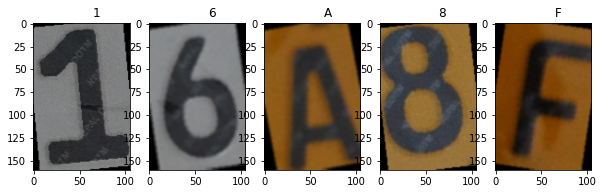

In [8]:
def train_imshow():
    classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'F') # Defining the classes we have
    dataiter = iter(train_load)
    images, labels = dataiter.next()
    fig, axes = plt.subplots(figsize=(10, 4), ncols=5)
    for i in range(5):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0)) 
        ax.title.set_text(' '.join('%5s' % classes[labels[i]]))
    plt.show()
    
train_imshow()

torch.Size([3, 160, 105])


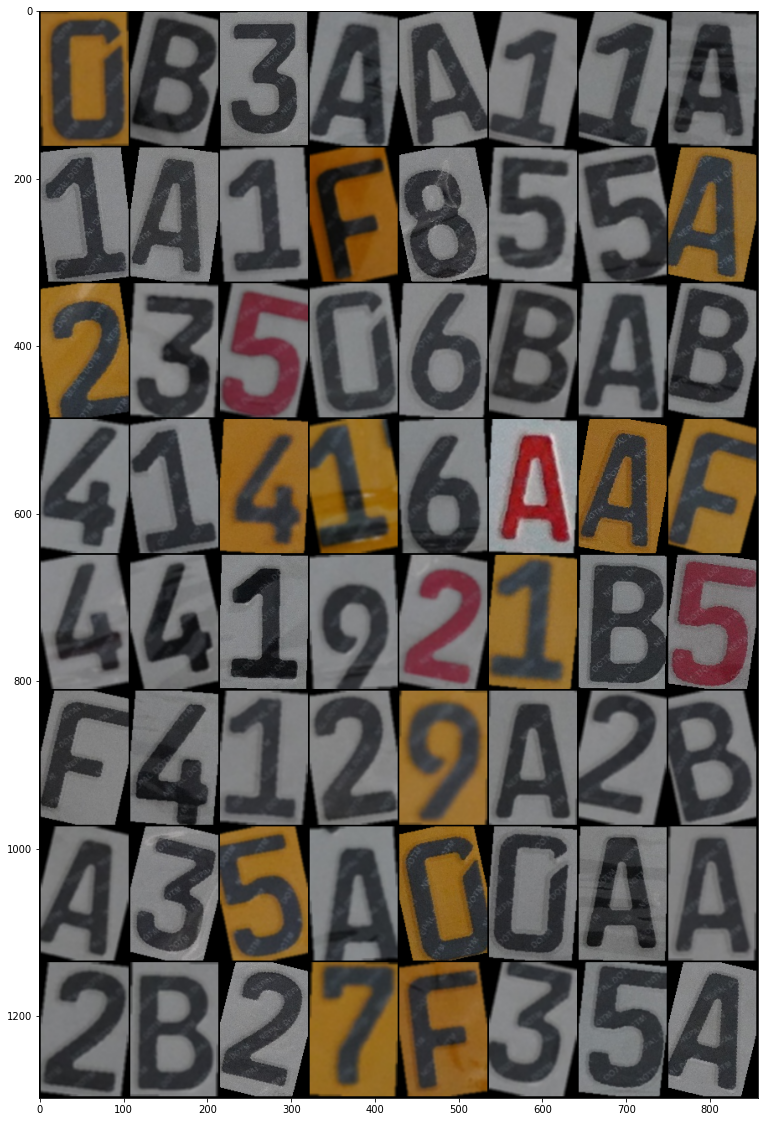

In [9]:
dataiter = iter(train_load)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
print(images[1].shape)

#### Model

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Layer 1
        self.cnn11 = nn.Conv2d(in_channels=3, out_channels=16,
                              kernel_size=3, stride=1, padding=1)
        self.cnn12 = nn.Conv2d(in_channels=16, out_channels=16,
                              kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(16)

        # Layer 2
        self.cnn21 = nn.Conv2d(in_channels=16, out_channels=32,
                              kernel_size=3, stride=1, padding=0)
        self.cnn22 = nn.Conv2d(in_channels=32, out_channels=32,
                              kernel_size=3, stride=1, padding=0)
        self.batchnorm2 = nn.BatchNorm2d(32)

        # Layer 3
        self.cnn31 = nn.Conv2d(in_channels=32, out_channels=64,
                              kernel_size=3, stride=1, padding=0)
        self.cnn32 = nn.Conv2d(in_channels=64, out_channels=64,
                              kernel_size=3, stride=1, padding=0)
        self.batchnorm3 = nn.BatchNorm2d(64)

        # Layer 4
        self.cnn41 = nn.Conv2d(in_channels=64, out_channels=128,
                              kernel_size=3, stride=1, padding=0)
        self.cnn42 = nn.Conv2d(in_channels=128, out_channels=128,
                              kernel_size=3, stride=1, padding=0)
        self.cnn43 = nn.Conv2d(in_channels=128, out_channels=128,
                              kernel_size=3, stride=1, padding=0)
        self.batchnorm4 = nn.BatchNorm2d(128)

        # Flatten
        self.fc1 = nn.Linear(in_features=2304, out_features=500)
        self.droput = nn.Dropout(p=0.5)  # Dropout used to reduce overfitting
        self.fc2 = nn.Linear(in_features=500, out_features=13)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True)

    def forward(self, x):
        # Layer 1
        out = self.cnn11(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.cnn12(out)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        # Layer 2
        out = self.cnn21(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.cnn22(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        # Layer 3
        out = self.cnn31(out)
        out = self.batchnorm3(out)
        out = self.relu(out)
        out = self.cnn32(out)
        out = self.batchnorm3(out)
        out = self.relu(out)
        out = self.maxpool(out)
        # Layer 4
        out = self.cnn41(out)
        out = self.batchnorm4(out)
        out = self.relu(out)
        out = self.cnn42(out)
        out = self.batchnorm4(out)
        out = self.relu(out)
        out = self.cnn43(out)
        out = self.batchnorm4(out)
        out = self.relu(out)
        out = self.maxpool(out)
        #Flattening is done here with .view() -> (batch_size, 128*6*3) = (100, 2304)
        # -1 will automatically update the batchsize as 100; 2304 flattens 128,6,3
        out = out.view(-1, 2304)
        #Then we forward through our fully connected layer
        out = self.fc1(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc2(out)
        return out

In [11]:
model = CNN()
# CUDA = torch.cuda.is_available()
# if CUDA:
#     model = model.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [12]:
from torchsummary import summary
summary(model, (3, 160, 105))
# print(CUDA)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 160, 105]             448
       BatchNorm2d-2         [-1, 16, 160, 105]              32
              ReLU-3         [-1, 16, 160, 105]               0
            Conv2d-4         [-1, 16, 160, 105]           2,320
       BatchNorm2d-5         [-1, 16, 160, 105]              32
              ReLU-6         [-1, 16, 160, 105]               0
         MaxPool2d-7           [-1, 16, 80, 53]               0
            Conv2d-8           [-1, 32, 78, 51]           4,640
       BatchNorm2d-9           [-1, 32, 78, 51]              64
             ReLU-10           [-1, 32, 78, 51]               0
           Conv2d-11           [-1, 32, 76, 49]           9,248
      BatchNorm2d-12           [-1, 32, 76, 49]              64
             ReLU-13           [-1, 32, 76, 49]               0
        MaxPool2d-14           [-1, 32,

#### Training Testing

In [ ]:
%%time
import time

#Define the lists to store the results of loss and accuracy
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

# def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
#     print("=> Saving checkpoint")
#     torch.save(state, filename)


# def load_checkpoint(checkpoint, model, optimizer):
#     print("=> Loading checkpoint")
#     model.load_state_dict(checkpoint["state_dict"])
#     optimizer.load_state_dict(checkpoint["optimizer"])
    
# if load_model:
#   load_checkpoint(torch.load("/content/drive/MyDrive/Major Project/Working/checkpoints/my_checkpoint.pth.tar"))

# Training
def train_model(num_epochs):
  for epoch in range(num_epochs):
    start = time.time()

    # Training Model
    running_loss = 0.0
    correct = 0
    iterations = 0
    n_total = 0
    iter_loss = 0.0

    for i, data in enumerate(train_load):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward 
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      iter_loss += loss.data.item()      # Accumulate the loss
      
      # backward + optimize
      loss.backward()
      optimizer.step()

      # Record the correct predictions for training data 
      _, predicted = torch.max(outputs, 1)
      n_total += labels.size(0)
      correct += (predicted == labels).sum()
      iterations += 1

    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / n_total))

    # Testing Evaluation
    loss = 0.0
    correct = 0
    n_total = 0
    iterations = 0

    model.eval()    # Put network in evaluation mode
    for i, data in enumerate(test_load):
      inputs, labels = data
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      loss += loss.data.item()
      _, predicted = torch.max(outputs, 1)
      n_total += labels.size(0)
      correct += (predicted == labels).sum()

      iterations += 1

    # Record the Testing loss
    val_loss.append(loss/iterations)
    # Record the Testing Accuracy
    val_accuracy.append((100 * correct / n_total))
    
    stop = time.time()

    print ('Epoch [{}/{}], Training Loss: {}, Training Acc.: {}, Validation Loss: {}, Validation Acc.: {}, Time: {}s'
           .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], val_loss[-1], val_accuracy[-1], stop-start))

    # Checkpoint: Save the model at every epoch
    save_path = f'/content/drive/MyDrive/Major Project/Working/Checkpoints/25Jan/model-epoch-{epoch+1}.pth'
    torch.save(model, save_path)
    save_path = f'/content/drive/MyDrive/Major Project/Working/Checkpoints/25Jan/model-epoch-{epoch+1}-statedict.pth'
    torch.save(model.state_dict(), save_path)
    
  print('Finished Training')

train_model(num_epochs)

# Run this if you want to save the model at the end
# PATH_m = '/content/drive/MyDrive/Major Project/Working/models/ALPR_cnn_model.pth'  # Drive
# PATH_m = 'D:\Segments_Sorted/ALPR_cnn_model_statedict.pth'  # HPC
# torch.save(model.state_dict(), '/content/drive/MyDrive/Major Project/Working/models/ALPR_cnn_model_color_10_statedict.pth')
# torch.save(model, PATH_m)

# Loading the trained network
# model.load_state_dict(torch.load(PATH_m))

Epoch [1/80], Training Loss: 2.462749566350664, Training Acc.: 19.385343551635742, Validation Loss: 1.232231855392456, Validation Acc.: 27.48815155029297, Time: 42.18133616447449s
Epoch [2/80], Training Loss: 2.2939126236098155, Training Acc.: 25.177305221557617, Validation Loss: 1.0962562561035156, Validation Acc.: 27.48815155029297, Time: 34.75947594642639s
Epoch [3/80], Training Loss: 1.8289253285952978, Training Acc.: 42.3167839050293, Validation Loss: 0.9139634966850281, Validation Acc.: 64.4549789428711, Time: 34.25293493270874s
Epoch [4/80], Training Loss: 0.7004950647907597, Training Acc.: 78.6052017211914, Validation Loss: 0.09576669335365295, Validation Acc.: 90.9952621459961, Time: 35.75956702232361s
Epoch [5/80], Training Loss: 0.2952182835766247, Training Acc.: 88.77068328857422, Validation Loss: 0.05778367444872856, Validation Acc.: 92.41706085205078, Time: 33.18603515625s
Epoch [6/80], Training Loss: 0.1658723113526191, Training Acc.: 94.9172592163086, Validation Loss: 0

In [ ]:
PATH_m ='/content/drive/MyDrive/Major Project/Working/Checkpoints/checkpoints_CV/model-fold-1-19.pth' # Drive
model.load_state_dict(torch.load(PATH_m))

<All keys matched successfully>

#### Result

In [ ]:
print('[INFO] Plotting after 4 epochs:')
# Plotting the training and validation loss
# plt.plot(train_loss[13:], label='Training Loss')
plt.plot(val_loss[13:], label='Validation Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.plot(train_accuracy[13:], label='Training Accuracy')
plt.plot(val_accuracy[13:], label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
selection = 4; 

fig, ax1 = plt.subplots()
x= [i for i in range(15,51)]
color = 'tab:red'
ax1.set_xlabel('epoch')
ax1.set_ylabel('train_loss', color=color)
ax1.plot(x,train_loss[selection:], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('test_loss', color=color)  # we already handled the x-label with ax1
ax2.plot(x,val_loss[selection:], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
path ='/content/drive/MyDrive/Major Project/Working/misclassified/'
from torchvision.utils import save_image
from google.colab.patches import cv2_imshow
n_correct = 0
n_total = 0
d = []
count = 0 
with torch.no_grad():
    for data in test_load:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        d =[i for i in range(len(labels)) if labels[i]  != predicted[i]]
        for i in d:
          save_image(images[i]/ 2 + 0.5, path+str(predicted[i].item())+'_count_'+str(count)+'.png')
          count +=1
        
with torch.no_grad():
    for data in train_load:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        d =[i for i in range(len(labels)) if labels[i]  != predicted[i]]
        for i in d:
          save_image(images[i]/ 2 + 0.5, path+str(predicted[i].item())+'_count_'+str(count)+'.png')
          count+=1
# acc = 100 * n_correct / n_total
print(f'Accuracy of the network on the {len(test_load)} test batch images: {count}')

Accuracy of the network on the 5 test batch images: 190


In [ ]:
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(13)]
  n_class_samples = [0 for i in range(13)]
  batch_size = 100
  for images, labels in test_load:
      outputs = model(images)
      # max returns (value ,index)
      _, predicted = torch.max(outputs, 1)
      n_samples += labels.size(0)
      n_correct += (predicted == labels).sum().item()
      # print(labels.size())
      for i in range(len(labels)):
          label = labels[i]
          pred = predicted[i]
          if (label == pred):
              n_class_correct[label] += 1
          n_class_samples[label] += 1

  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')

  for i in range(13):
      acc = 100.0 * n_class_correct[i] / n_class_samples[i]
      print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 97.24409448818898 %
Accuracy of 0: 100.0 %
Accuracy of 1: 100.0 %
Accuracy of 2: 100.0 %
Accuracy of 3: 100.0 %
Accuracy of 4: 100.0 %
Accuracy of 5: 87.5 %
Accuracy of 6: 94.11764705882354 %
Accuracy of 7: 100.0 %
Accuracy of 8: 87.5 %
Accuracy of 9: 80.0 %
Accuracy of A: 96.66666666666667 %
Accuracy of B: 100.0 %
Accuracy of F: 100.0 %


Predicted:      A     4     8     8


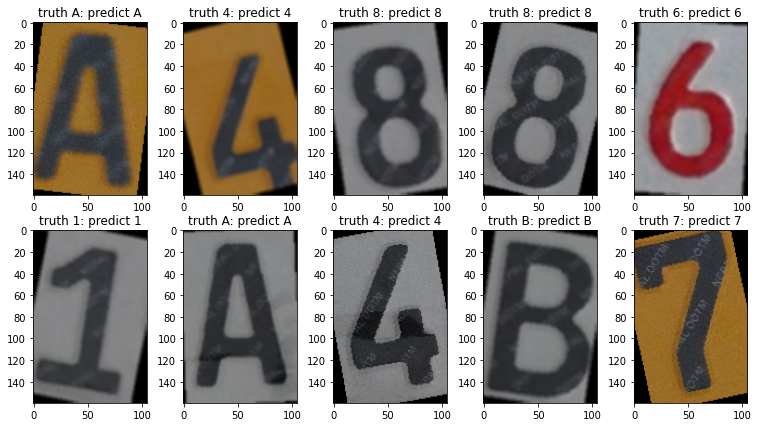

In [ ]:
# Print Prediction

#make an iterator from test_loader
#Get a batch of training images
test_iterator = iter(test_load)
images, labels = test_iterator.next()

results = model(images)
_, predicted = torch.max(results, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

rows = 2
columns = 5
fig = plt.figure(figsize=(13,7))
for i in range(10):
   fig.add_subplot(rows, columns, i+1)
   plt.title('truth ' + classes[labels[i]] + ': predict ' + classes[predicted[i]])
   img = images[i]  # this is to unnormalize the image
   img = torchvision.transforms.ToPILImage()(img)
   plt.imshow(img)
plt.show()

[INFO] classifying image...
B: 82.148%
0: 17.309%
9: 0.353%
F: 0.112%
8: 0.065%
5: 0.009%
2: 0.001%
3: 0.001%
A: 0.001%
7: 0.000%
6: 0.000%
1: 0.000%
4: 0.000%


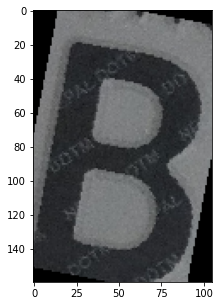

In [ ]:
# Checking image confidence

#make an iterator from test_loader
#Get a batch of training images
test_iterator = iter(test_load)
images, labels = test_iterator.next()

def imshow2(img):
    img = img
    npimg = img.numpy()
    plt.figure(figsize=(5, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
imshow2(images[0,:,:,:])

# classify the image and extract the predictions
print("[INFO] classifying image...")
with torch.no_grad():
    output = model(images)

probabilities = torch.nn.Softmax(dim=-1)(output)
sortedProba = torch.argsort(probabilities, dim=-1, descending=True)
predictions = np.argmax(list(probabilities.numpy()), axis=1)

# loop over the predictions and display the rank-13 predictions and
# corresponding probabilities to our terminal
for (i, idx) in enumerate(sortedProba[0, :13]):
  print("{}: {:.3f}%".format(classes[idx.item()].strip(), probabilities[0, idx.item()] * 100))

# print(sortedProba[0,0].numpy())
# print('Predictions: ', predictions)


#### Using k-fold CrossValidation

--------------------------------
FOLD 0
--------------------------------
Reset trainable parameters of layer = Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainabl

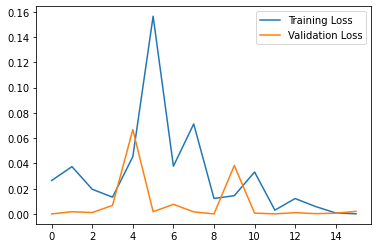

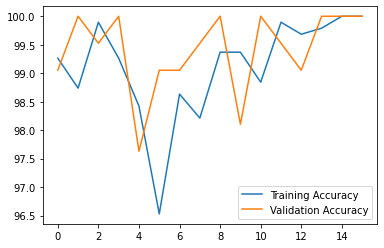

Accuracy for fold 0: 100 %
--------------------------------
Accuracy of 0: 100.0 %
Accuracy of 1: 100.0 %
Accuracy of 2: 100.0 %
Accuracy of 3: 100.0 %
Accuracy of 4: 100.0 %
Accuracy of 5: 100.0 %
Accuracy of 6: 100.0 %
Accuracy of 7: 100.0 %
Accuracy of 8: 100.0 %
Accuracy of 9: 100.0 %
Accuracy of A: 100.0 %
Accuracy of B: 100.0 %
Accuracy of F: 100.0 %
FOLD 1
--------------------------------
Reset trainable parameters of layer = Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_ru

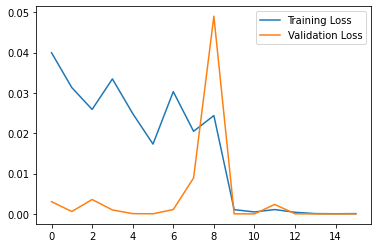

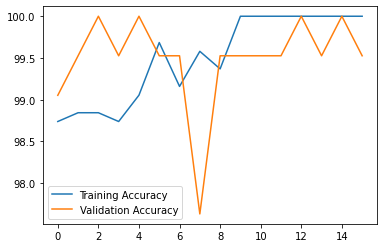

Accuracy for fold 1: 98 %
--------------------------------
Accuracy of 0: 100.0 %
Accuracy of 1: 100.0 %
Accuracy of 2: 100.0 %
Accuracy of 3: 100.0 %
Accuracy of 4: 100.0 %
Accuracy of 5: 100.0 %
Accuracy of 6: 100.0 %
Accuracy of 7: 100.0 %
Accuracy of 8: 100.0 %
Accuracy of 9: 66.66666666666667 %
Accuracy of A: 100.0 %
Accuracy of B: 100.0 %
Accuracy of F: 100.0 %
FOLD 2
--------------------------------
Reset trainable parameters of layer = Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=Tru

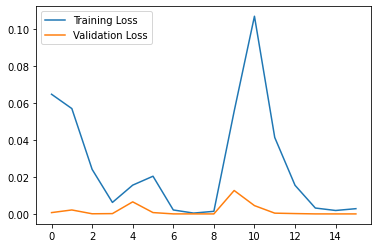

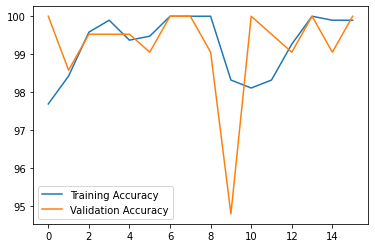

Accuracy for fold 2: 99 %
--------------------------------
Accuracy of 0: 100.0 %
Accuracy of 1: 100.0 %
Accuracy of 2: 100.0 %
Accuracy of 3: 100.0 %
Accuracy of 4: 100.0 %
Accuracy of 5: 100.0 %
Accuracy of 6: 100.0 %
Accuracy of 7: 100.0 %
Accuracy of 8: 80.0 %
Accuracy of 9: 100.0 %
Accuracy of A: 100.0 %
Accuracy of B: 100.0 %
Accuracy of F: 100.0 %
FOLD 3
--------------------------------
Reset trainable parameters of layer = Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_runn

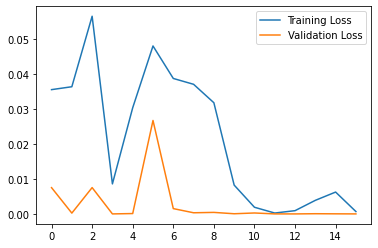

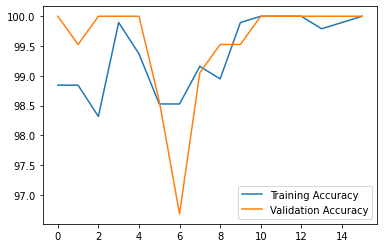

Accuracy for fold 3: 100 %
--------------------------------
Accuracy of 0: 100.0 %
Accuracy of 1: 100.0 %
Accuracy of 2: 100.0 %
Accuracy of 3: 100.0 %
Accuracy of 4: 100.0 %
Accuracy of 5: 100.0 %
Accuracy of 6: 100.0 %
Accuracy of 7: 100.0 %
Accuracy of 8: 100.0 %
Accuracy of 9: 100.0 %
Accuracy of A: 100.0 %
Accuracy of B: 100.0 %
Accuracy of F: 100.0 %
FOLD 4
--------------------------------
Reset trainable parameters of layer = Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_ru

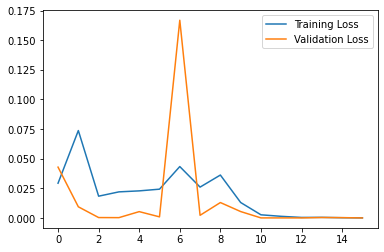

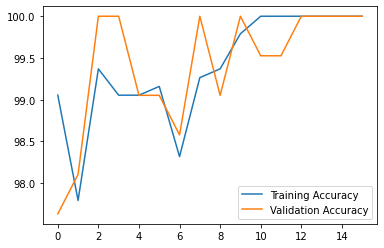

Accuracy for fold 4: 100 %
--------------------------------
Accuracy of 0: 100.0 %
Accuracy of 1: 100.0 %
Accuracy of 2: 100.0 %
Accuracy of 3: 100.0 %
Accuracy of 4: 100.0 %
Accuracy of 5: 100.0 %
Accuracy of 6: 100.0 %
Accuracy of 7: 100.0 %
Accuracy of 8: 100.0 %
Accuracy of 9: 100.0 %
Accuracy of A: 100.0 %
Accuracy of B: 100.0 %
Accuracy of F: 100.0 %
FOLD 5
--------------------------------
Reset trainable parameters of layer = Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_ru

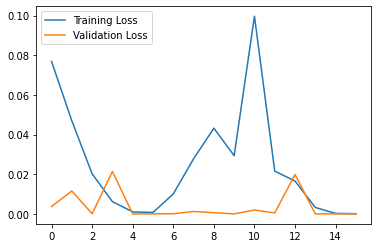

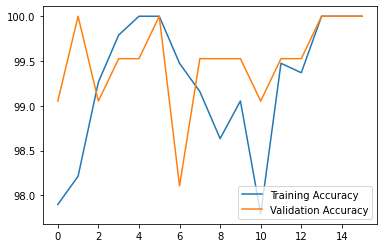

Accuracy for fold 5: 99 %
--------------------------------
Accuracy of 0: 100.0 %
Accuracy of 1: 100.0 %
Accuracy of 2: 100.0 %
Accuracy of 3: 100.0 %
Accuracy of 4: 100.0 %
Accuracy of 5: 100.0 %
Accuracy of 6: 100.0 %
Accuracy of 7: 100.0 %
Accuracy of 8: 100.0 %
Accuracy of 9: 100.0 %
Accuracy of A: 96.42857142857143 %
Accuracy of B: 100.0 %
Accuracy of F: 100.0 %
FOLD 6
--------------------------------
Reset trainable parameters of layer = Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=Tru

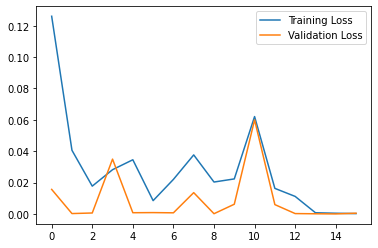

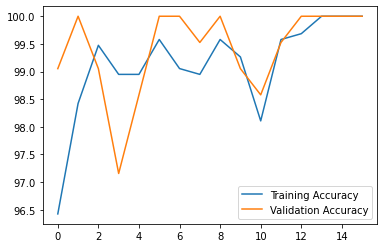

Accuracy for fold 6: 99 %
--------------------------------
Accuracy of 0: 100.0 %
Accuracy of 1: 100.0 %
Accuracy of 2: 100.0 %
Accuracy of 3: 75.0 %
Accuracy of 4: 100.0 %
Accuracy of 5: 100.0 %
Accuracy of 6: 100.0 %
Accuracy of 7: 100.0 %
Accuracy of 8: 100.0 %


ZeroDivisionError: ignored

In [ ]:
%%time
import time

# 10-k Cross Validation
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

# Configuration options
k_folds = 10
num_epochs = 20
batch_size = 32
loss_function = nn.CrossEntropyLoss()

# For fold results
results = {}

# For accuracy
acc_network, acc_0, acc_1, acc_2, acc_3, acc_4, acc_5, acc_6, acc_7, acc_8, acc_9, acc_A, acc_B, acc_F = ([] for i in range(14))

# Set fixed random number seed
torch.manual_seed(42)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)
  
# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(train_dataset)):
  
  # Print
  print(f'FOLD {fold}')
  print('--------------------------------')
  
  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  
  # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(
                    train_dataset, 
                    batch_size=batch_size, sampler=train_subsampler)
  testloader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=batch_size, sampler=test_subsampler)
  
  # Init the neural network
  model = CNN()
  model.apply(reset_weights)
  
  # Initialize optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  
  #Define the lists to store the results of loss and accuracy
  train_loss = []
  val_loss = []
  train_accuracy = []
  val_accuracy = []

  # Run the training loop for defined number of epochs
  for epoch in range(0, num_epochs):
    start = time.time()

    # # Print epoch
    # print(f'Starting epoch {epoch+1}')

    # Set current values to zero
    current_loss = 0.0
    running_loss = 0.0
    correct = 0
    iterations = 0
    n_total = 0
    iter_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
      
      # Get inputs
      inputs, labels = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = model(inputs)
      
      # Compute loss
      loss = loss_function(outputs, labels)
      iter_loss += loss.data.item()      # Accumulate the loss

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Record the correct predictions for training data 
      _, predicted = torch.max(outputs, 1)
      n_total += labels.size(0)
      correct += (predicted == labels).sum()
      iterations += 1

      # # Print statistics on mini-batches
      # current_loss += loss.item()
      # # if i % len(train_load)  == (len(train_load)-1):
      # if i % 5  == 0:
      #     print('Loss after mini-batch %5d: %.6f' %
      #           (i + 1, current_loss / len(train_load)))
      #     current_loss = 0.0
      
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / n_total))

    ## Validation
    loss = 0.0
    correct = 0
    n_total = 0
    iterations = 0

    model.eval()    # Put network in evaluation mode
    for i, data in enumerate(test_load):
      inputs, labels = data
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      loss += loss.data.item()
      _, predicted = torch.max(outputs, 1)
      n_total += labels.size(0)
      correct += (predicted == labels).sum()

      iterations += 1

    # Record the Validation loss
    val_loss.append(loss/iterations)
    # Record the Validation Accuracy
    val_accuracy.append((100 * correct / n_total))
    
    stop = time.time()

    print ('Epoch [{}/{}], Training Loss: {}, Training Acc.: {}, Validation Loss: {}, Validation Acc.: {}, Time: {}s'
           .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], val_loss[-1],val_accuracy[-1], stop-start))
    
    # Saving the model
    save_path = f'/content/drive/MyDrive/Major Project/Working/checkpoints/model-fold-{fold}-epoch-{epoch+1}.pth'
    torch.save(model.state_dict(), save_path)
          
  # Process is complete.
  print('Training process has finished. Saving trained model.')
  
  # Saving the model
  save_path = f'/content/drive/MyDrive/Major Project/Working/checkpoints/model-fold-{fold}.pth'
  torch.save(model.state_dict(), save_path)

  # Print about testing
  print('Starting testing')

  # Evaluationfor this fold
  correct, total = 0, 0
  n_class_correct = [0 for i in range(13)]
  n_class_samples = [0 for i in range(13)]
  with torch.no_grad():

    # Iterate over the test data and generate predictions
    for i, data in enumerate(testloader, 0):

      # Get inputs
      inputs, labels = data

      # Generate outputs
      outputs = model(inputs)

      # Set total and correct
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      # Generate each class accuracy
      for i in range(len(labels)):
          label = labels[i]
          pred = predicted[i]
          if (label == pred):
              n_class_correct[label] += 1
          n_class_samples[label] += 1

    print('[INFO] Plotting after 4 epochs:')
    # Plotting the training and validation loss
    plt.plot(train_loss[4:], label='Training Loss')
    plt.plot(val_loss[4:], label='Validation Loss')
    plt.legend()
    plt.show()

    # Plotting the training and validation accuracy
    plt.plot(train_accuracy[4:], label='Training Accuracy')
    plt.plot(val_accuracy[4:], label='Validation Accuracy')
    plt.legend()
    plt.show()

    # Print accuracy
    print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
    print('--------------------------------')
    results[fold] = 100.0 * (correct / total)
    acc_network.append(results[fold])

    for i in range(13):
      acc = 100.0 * n_class_correct[i] / n_class_samples[i]
      print(f'Accuracy of {classes[i]}: {acc} %')

  
# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  sum += value
print(f'Average: {sum/len(results.items())} %')

#### Extra

In [ ]:
data_path = '/content/drive/MyDrive/Major Project/Working/images/Segments_Sorted/'
save_path = '/content/drive/MyDrive/Major_Project/New Dataset/'
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'F']
transform_ori = transforms.Compose([transforms.RandomRotation(15, expand=False), 
                                    transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
                                    transforms.ToTensor(),  # convert the image to a Tensor,
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  # normalize the image
train_dataset = datasets.ImageFolder(data_path, transform=transform_ori)

indices = list(range(num_train))
train_sampler = SubsetRandomSampler(indices)
batch_size = 1
train_load = torch.utils.data.DataLoader(train_dataset,
                                         sampler=train_sampler, batch_size=batch_size)

In [ ]:
from torchvision.utils import save_image
# im.save("your_file.jpeg")

In [ ]:
index = 0
arr = []
for i, data in enumerate(train_load):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      for j in labels:
        arr.append(j.item())
      # image_tensor= inputs[0]
      
   
      # save_image(image_tensor, save_path+str(labels.item())+"/"+str(index)+".jpeg")
      # index = index+1
for i, data in enumerate(test_load):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      for j in labels:
        arr.append(j.item())
      # image_tensor= inputs[0]
      
   
      # save_image(image_tensor, save_path+str(labels.item())+"/"+str(index)+".jpeg")
      # index = index+1


In [ ]:
unique, counts = np.unique(arr, return_counts=True)

print(np.asarray((unique, counts)).T)

In [ ]:
import os, os.path

# simple version for working with CWD

# path joining version for other paths
for name in os.listdir(data_path):
  print(name+":"+str(len([n for n in os.listdir(data_path+name) ])))


0:89
4:45
3:39
1:134
9:20
5:61
8:52
6:62
7:41
2:61
B:108
F:74
A:271
